# <a id="table-of-contents"></a>Table of Contents

1. [Intraday Mean Reversion](#section1)
2. [Moving Average](#section2)


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay,  roc_curve, roc_auc_score, average_precision_score


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from arch import arch_model


In [2]:
# Define the path to the Downloads folder and the file
downloads_folder = os.path.expanduser("~/Desktop")
file_name = "aaHistoricalData_1726248252859.csv" 
file_path = os.path.join(downloads_folder, file_name)

# Read the CSV file into a DataFrame
data = pd.read_csv(file_path)

In [3]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Sort the DataFrame by date in ascending order
data = data.sort_values(by='Date', ascending=True)

print(data.head(3))

           Date  Close/Last     Volume    Open    High     Low
2515 2014-09-15     198.981   76350030  199.16  199.32  198.38
2514 2014-09-16     200.480  116039000  198.61  200.84  198.50
2513 2014-09-17     200.750  149647200  200.77  201.68  199.75


In [4]:
# Assuming 'data' is your existing DataFrame
data['Original_Index'] = data.index  # Add the Original_Index column to capture current index
print('''It will record the INDEX to make sure that future data manipulations don't force us to lose the order.''')

It will record the INDEX to make sure that future data manipulations don't force us to lose the order.


In [5]:
# Add new columns with the given calculations
data['High_minus_Open'] = (data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)
data['day_change'] = (data['Close/Last'] - data['Close/Last'].shift(1)) / data['Close/Last'].shift(1)

data['opening_gaps'] = (data['Open'] - data['Close/Last'].shift(1)) / ((data['Open'] + data['Close/Last']) / 2)

#YOU DEFINED OPENNING GAPS AS TODAY'S OPEN TO YESTERDAY'S CLOSE INSTEAD OF TODAY'S OPEN TO YESTERDAY'S HIGH/LOW..


data['net_Intraday_Movement_Around_Open_Ratio'] = ((data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)) - ((data['Open'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2))
data['Intraday_Volatility'] = ((data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)) + ((data['Open'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2))

# Calculate day change adjusted for opening gap
data['day_change_adjusted_for_openning_gap'] = data['day_change'] - data['opening_gaps']


# Create moving average columns
data['MA_5'] = data['Open'].rolling(window=5).mean()
data['MA_14'] = data['Open'].rolling(window=14).mean()
data['MA_50'] = data['Open'].rolling(window=50).mean()
data['MA_200'] = data['Open'].rolling(window=200).mean()


# Create lagged features comparing today's open to these moving averages
data['open_above_MA_5'] = (data['Open'] > data['MA_5']).astype(int)
data['open_above_MA_14'] = (data['Open'] > data['MA_14']).astype(int)
data['open_above_MA_50'] = (data['Open'] > data['MA_50']).astype(int)

# Create a crossover signal column
data['MA_Crossover_Signal_5_14'] = ((data['MA_5'] > data['MA_14']) & (data['MA_5'].shift(1) <= data['MA_5'].shift(1))).astype(int)
data['MA_Crossover_Signal_today_5'] = ((data['Close/Last'] > data['MA_14']) & (data['Close/Last'].shift(1) <= data['MA_5'].shift(1))).astype(int)


# Create a binary indicator for whether yesterday's close was above or below the 5-day MA
data['yesterday_close_above_MA_5'] = (data['Close/Last'].shift(1) > data['MA_14']).astype(int)


## <a id="section2"></a> Moving Averages: Today's Price Change

In [6]:
# Loop over each moving average period from 1 to 50 days
for i in range(1, 51):
    ma_column = f'open_above_MA_{i}'
    data[ma_column] = data['Open'].rolling(window=i).mean()

# Calculate the binary variables to check if the opening price is above the moving averages
for i in range(1, 51):
    ma_column = f'open_above_MA_{i}'
    data[ma_column] = (data['Open'] > data[ma_column]).astype(int)

# Drop rows with NaN values in the newly created columns
columns_of_interest = [f'open_above_MA_{i}' for i in range(1, 51)]
data.dropna(subset=columns_of_interest, inplace=True)




Significant Moving Averages with Coefficients > 0.4:
    Moving Average  Coefficient       P-Value  Odds Ratio  Probability  \
0                2     0.914357  1.306516e-28    2.495170     0.713891   
1                3     0.783759  1.501753e-21    2.189687     0.686490   
2                4     0.737372  3.168717e-19    2.090435     0.676421   
3                5     0.681289  1.279870e-16    1.976424     0.664026   
4                6     0.639606  8.002875e-15    1.895734     0.654664   
5                7     0.592777  7.415684e-13    1.809006     0.644002   
6                8     0.524033  2.204753e-10    1.688825     0.628090   
8               10     0.493813  2.709581e-09    1.638552     0.621004   
7                9     0.477810  7.790575e-09    1.612538     0.617231   
9               11     0.467724  2.024844e-08    1.596358     0.614845   
10              12     0.463393  2.948047e-08    1.589457     0.613819   
11              13     0.445060  1.075604e-07    1.560584 

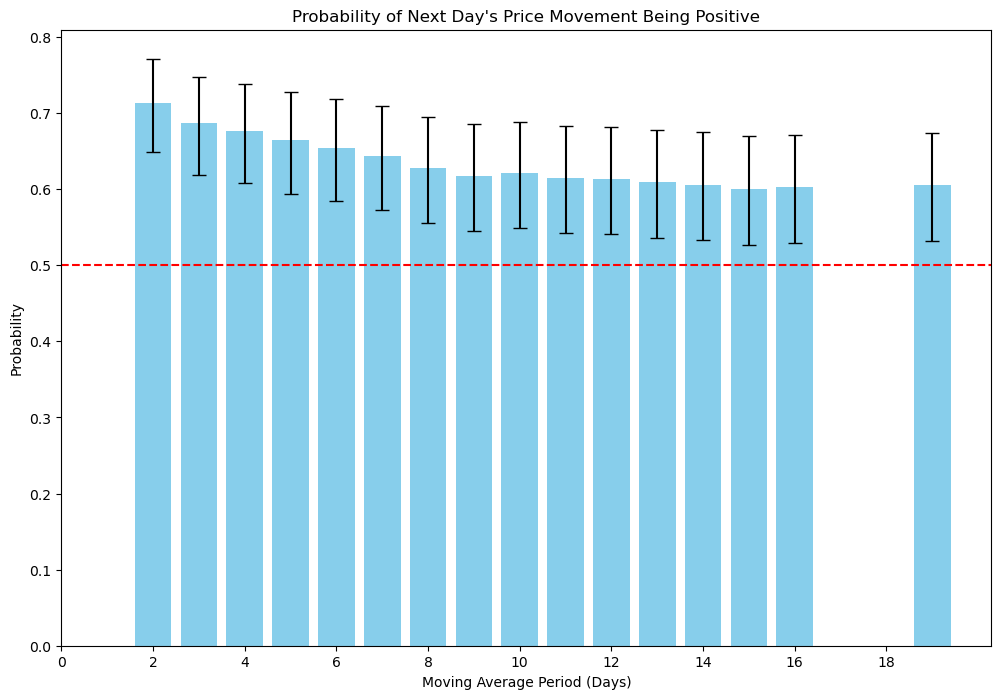


The logistic regression analysis confirms that shorter-term moving averages are significant predictors of the next day's price movement. Next steps would be
to determine if there is any information in the later moving averages.. say 14 that is not included or already encapsulated in the 5 day.

 
You're correct that multicollinearity is not a concern when using a single moving average as the predictor. Your approach to isolate and select the most 
predictive moving average is sound.



In [18]:
# Drop rows with NaN values in the columns of interest and explicitly make a copy
clean_data = data.copy()

# Logistic regression preparation: Convert 'day_change' to binary (0 for Down, 1 for Up)
clean_data['day_change'] = clean_data['day_change'].apply(lambda x: 1 if x > 0 else 0)

# Ensure all columns are numeric
clean_data = clean_data.apply(pd.to_numeric, errors='coerce')

# Convert boolean columns to integers
for i in range(2, 51):
    ma_column = f'open_above_MA_{i}'
    if ma_column in clean_data.columns:
        clean_data[ma_column] = clean_data[ma_column].astype(int)

# Drop rows with NaN values in the 'day_change' column and moving average columns
columns_of_interest = ['day_change'] + [f'open_above_MA_{i}' for i in range(2, 51)]
clean_data = clean_data.dropna(subset=columns_of_interest)

# Prepare a list to collect results
results_list = []

# Loop over each moving average from 2 to 50 days
for i in range(2, 51):
    ma_column = f'open_above_MA_{i}'
    if ma_column in clean_data.columns:
        X = clean_data[[ma_column]]
        y = clean_data['day_change']
        
        # Add a constant term to the predictor
        X = sm.add_constant(X)
        
        # Fit the logistic regression model
        model = sm.Logit(y, X)
        result = model.fit(disp=0)  # disp=0 suppresses the output
        
        # Extract coefficient and p-value
        coef = result.params[ma_column]
        p_value = result.pvalues[ma_column]
        
        # Only collect significant results with beta > 0.4
        if p_value < 0.05 and coef > 0.4:
            odds_ratio = np.exp(coef)
            prob = odds_ratio / (1 + odds_ratio)
            
            # Collect the results
            results_list.append({
                'Moving Average': i,
                'Coefficient': coef,
                'P-Value': p_value,
                'Odds Ratio': odds_ratio,
                'Probability': prob
            })

# Convert results list to a DataFrame
results_summary = pd.DataFrame(results_list)

# Calculate confidence intervals for odds ratios and probabilities
results_summary['Odds Ratio Lower Bound'] = np.exp(results_summary['Coefficient'] - 1.96 * results_summary['Coefficient'].std())
results_summary['Odds Ratio Upper Bound'] = np.exp(results_summary['Coefficient'] + 1.96 * results_summary['Coefficient'].std())
results_summary['Probability Lower Bound'] = results_summary['Odds Ratio Lower Bound'] / (1 + results_summary['Odds Ratio Lower Bound'])
results_summary['Probability Upper Bound'] = results_summary['Odds Ratio Upper Bound'] / (1 + results_summary['Odds Ratio Upper Bound'])

# Sort results by coefficient for better readability
results_summary_sorted = results_summary.sort_values(by='Coefficient', ascending=False)

# Print the results
print("\nSignificant Moving Averages with Coefficients > 0.4:")
print(results_summary_sorted)

# Plot stacked bar graph of probabilities with confidence intervals
plt.figure(figsize=(12, 8))
plt.bar(results_summary_sorted['Moving Average'], results_summary_sorted['Probability'], yerr=[results_summary_sorted['Probability'] - results_summary_sorted['Probability Lower Bound'], results_summary_sorted['Probability Upper Bound'] - results_summary_sorted['Probability']], capsize=5, color='skyblue')
plt.xlabel('Moving Average Period (Days)')
plt.ylabel('Probability')
plt.title('Probability of Next Day\'s Price Movement Being Positive')
plt.xticks(ticks=np.arange(0, 20, 2), labels=np.arange(0, 20, 2))
plt.axhline(y=0.5, color='red', linestyle='--')
plt.show()

print('''
The logistic regression analysis confirms that shorter-term moving averages are significant predictors of the next day's price movement. Next steps would be
to determine if there is any information in the later moving averages.. say 14 that is not included or already encapsulated in the 5 day.
''')

print(''' 
You're correct that multicollinearity is not a concern when using a single moving average as the predictor. Your approach to isolate and select the most 
predictive moving average is sound.
''')


In [19]:
# Copy and prepare the dataset
clean_data = data.copy()

# Logistic regression preparation: Convert 'day_change' to binary (0 for Down, 1 for Up)
clean_data['day_change'] = clean_data['day_change'].apply(lambda x: 1 if x > 0 else 0)

# Ensure all columns are numeric
clean_data = clean_data.apply(pd.to_numeric, errors='coerce')

# Convert boolean columns to integers
clean_data['open_above_MA_5'] = clean_data['open_above_MA_5'].astype(int)

# Drop rows with NaN values in the columns of interest
clean_data = clean_data.dropna(subset=['day_change', 'open_above_MA_5'])

# Define predictor and response variable
X = clean_data[['open_above_MA_5']]
y = clean_data['day_change']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the logistic regression model
model = sm.Logit(y, X)
result = model.fit(disp=0)

# Calculate the partial residuals
partial_residuals = result.resid_response + X['open_above_MA_5'] * result.params['open_above_MA_5']

# Plot partial residual plot
sns.regplot(X['open_above_MA_5'], partial_residuals, lowess=True, ci=None)
plt.xlabel('open_above_MA_5')
plt.ylabel('Partial Residuals')
plt.title('Partial Residual Plot for open_above_MA_5')
plt.show()


TypeError: regplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 2 keyword-only arguments) were given

/Users/nicholassanso/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nicholassanso/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nicholassanso/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nicholassanso/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


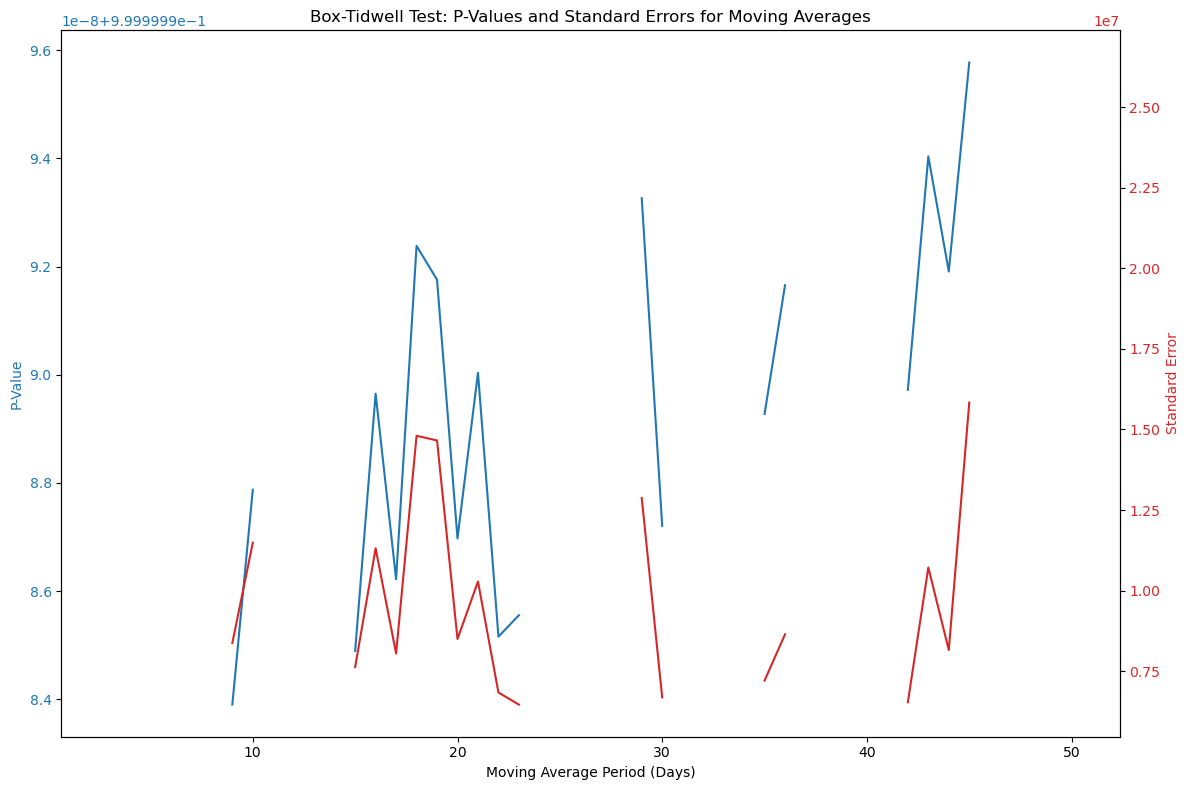

In [17]:
# Copy and prepare the dataset
clean_data = data.copy()

# Logistic regression preparation: Convert 'day_change' to binary (0 for Down, 1 for Up)
clean_data['day_change'] = clean_data['day_change'].apply(lambda x: 1 if x > 0 else 0)

# Ensure all columns are numeric
clean_data = clean_data.apply(pd.to_numeric, errors='coerce')

# Convert boolean columns to integers using .loc to avoid SettingWithCopyWarning
for i in range(2, 51):
    ma_column = f'open_above_MA_{i}'
    if ma_column in clean_data.columns:
        clean_data.loc[:, ma_column] = clean_data.loc[:, ma_column].astype(int)

# Drop rows with NaN values in the 'day_change' column and moving average columns
columns_of_interest = ['day_change'] + [f'open_above_MA_{i}' for i in range(2, 51)]
clean_data = clean_data.dropna(subset=columns_of_interest)

# Prepare a list to collect results
results_list = []

# Loop over each moving average from 2 to 50 days
for i in range(2, 51):
    ma_column = f'open_above_MA_{i}'
    if ma_column in clean_data.columns:
        X = clean_data[[ma_column]].copy()  # Create explicit copy to avoid SettingWithCopyWarning
        y = clean_data['day_change'].copy()
        
        # Apply Box-Tidwell transformation
        X.loc[:, f'log_{ma_column}'] = np.log(X[ma_column] + 1)
        X.loc[:, f'{ma_column}_interaction'] = X[ma_column] * X[f'log_{ma_column}']
        
        # Add a constant term to the predictor
        X = sm.add_constant(X)
        
        # Fit the logistic regression model
        model = sm.Logit(y, X)
        result = model.fit(disp=0)  # disp=0 suppresses the output
        
        # Extract coefficient, standard error, and p-value for the interaction term
        interaction_coef = result.params[f'{ma_column}_interaction']
        interaction_std_err = result.bse[f'{ma_column}_interaction']
        interaction_p_value = result.pvalues[f'{ma_column}_interaction']
        
        # Collect the results
        results_list.append({
            'Moving Average': i,
            'Interaction Coefficient': interaction_coef,
            'Standard Error': interaction_std_err,
            'P-Value': interaction_p_value
        })

# Convert results list to a DataFrame
results_summary = pd.DataFrame(results_list)

# Plot the results
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot p-values on the left y-axis
color = 'tab:blue'
ax1.set_xlabel('Moving Average Period (Days)')
ax1.set_ylabel('P-Value', color=color)
ax1.plot(results_summary['Moving Average'], results_summary['P-Value'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for standard errors
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Standard Error', color=color)
ax2.plot(results_summary['Moving Average'], results_summary['Standard Error'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout adjustments
plt.title('Box-Tidwell Test: P-Values and Standard Errors for Moving Averages')
fig.tight_layout()
plt.show()


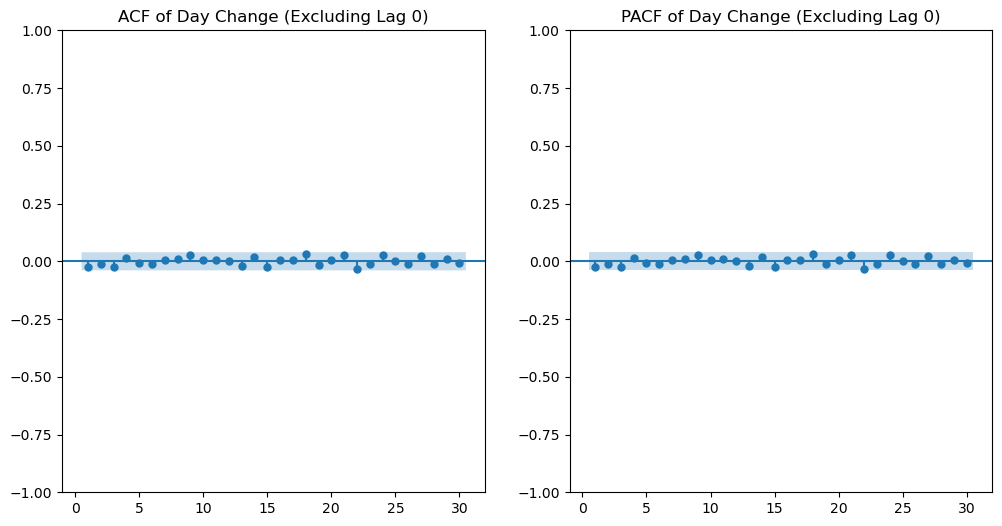


The below charts show that there is no temporal dependencies for the dependent variables with itself

Slow, gradual decline in ACF values suggest a trend in the data and is problematic. 

Values outside the shaded area, which represtns the two standard deviations is problematic



In [9]:
# Plot ACF and PACF for the 'day_change' variable excluding lag 0
plt.figure(figsize=(12, 6))

# ACF plot excluding lag 0
plt.subplot(121)
plot_acf(clean_data['day_change'], lags=30, zero=False, ax=plt.gca())
plt.title('ACF of Day Change (Excluding Lag 0)')

# PACF plot excluding lag 0
plt.subplot(122)
plot_pacf(clean_data['day_change'], lags=30, zero=False, ax=plt.gca())
plt.title('PACF of Day Change (Excluding Lag 0)')

plt.show()

print('''
The below charts show that there is no temporal dependencies for the dependent variables with itself

Slow, gradual decline in ACF values suggest a trend in the data and is problematic. 

Values outside the shaded area, which represtns the two standard deviations is problematic
''')


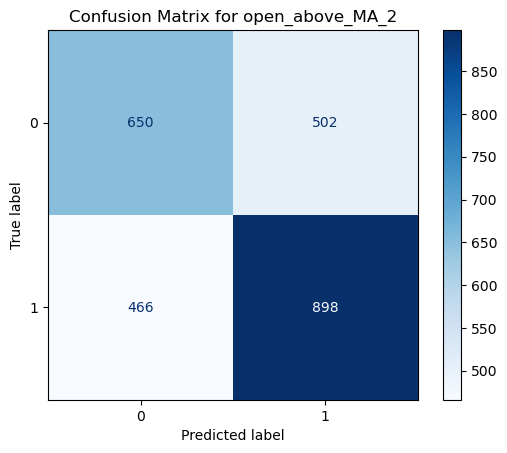

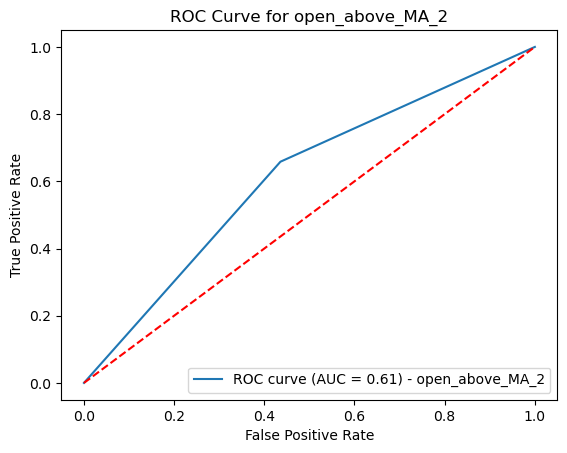

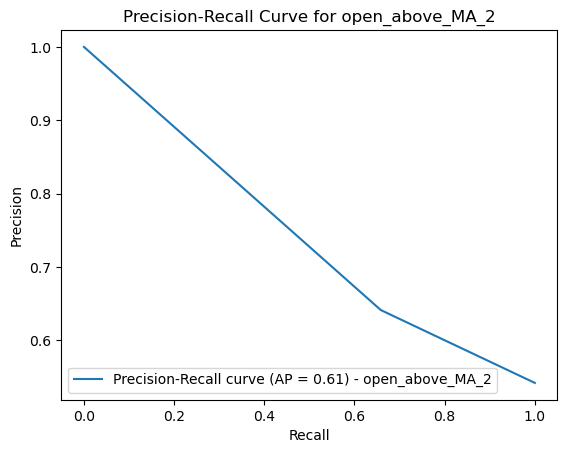

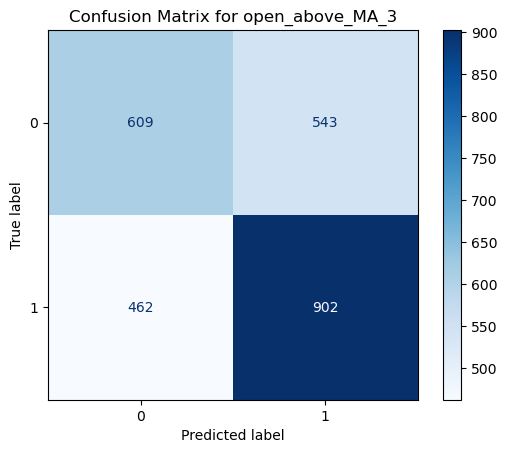

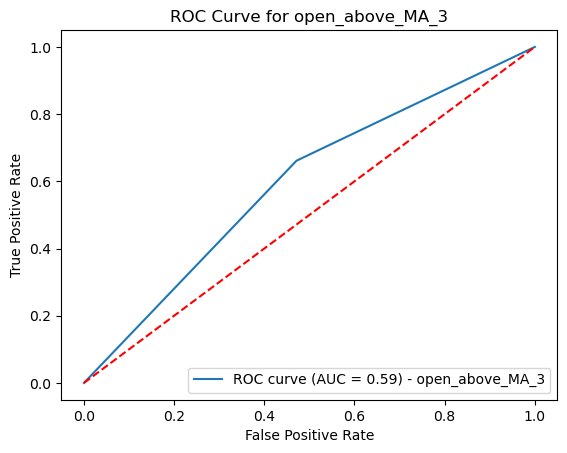

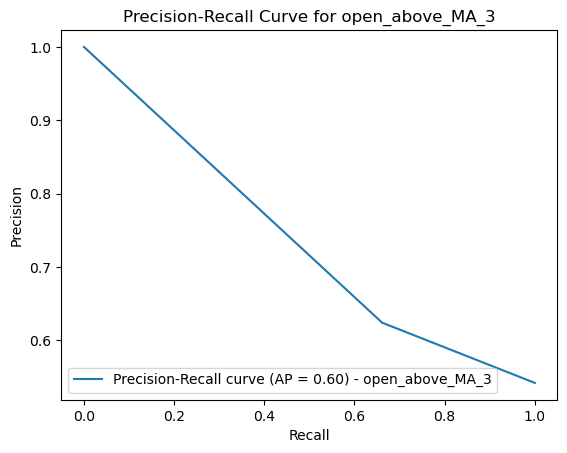

In [10]:
# Drop rows with NaN values in the columns of interest and explicitly make a copy
clean_data = data.copy()

# Logistic regression preparation: Convert 'day_change' to binary (0 for Down, 1 for Up)
clean_data['day_change'] = clean_data['day_change'].apply(lambda x: 1 if x > 0 else 0)

# Ensure all columns are numeric
clean_data = clean_data.apply(pd.to_numeric, errors='coerce')

# Convert boolean columns to integers
for i in range(2, 51):
    ma_column = f'open_above_MA_{i}'
    if ma_column in clean_data.columns:
        clean_data[ma_column] = clean_data[ma_column].astype(int)

# Drop rows with NaN values in the 'day_change' column and moving average columns
columns_of_interest = ['day_change'] + [f'open_above_MA_{i}' for i in range(2, 51)]
clean_data = clean_data.dropna(subset=columns_of_interest)

# Ensure the dependent variable is binary
assert clean_data['day_change'].isin([0, 1]).all(), "Dependent variable must be binary."

# Function to fit logistic regression and plot evaluation metrics
def evaluate_moving_average(ma_column):
    X = clean_data[[ma_column]]
    y = clean_data['day_change']
    
    # Add a constant term to the predictor
    X = sm.add_constant(X)
    
    # Fit the logistic regression model
    model = sm.Logit(y, X)
    result = model.fit(disp=0)  # disp=0 suppresses the output
    
    # Predict probabilities and classes
    y_pred_prob = result.predict(X)
    y_pred = (y_pred_prob >= 0.5).astype(int)
    
    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {ma_column}')
    plt.show()
    
    # ROC Curve and AUC
    fpr, tpr, _ = roc_curve(y, y_pred_prob)
    auc_score = roc_auc_score(y, y_pred_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f}) - {ma_column}')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {ma_column}')
    plt.legend(loc="lower right")
    plt.show()
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y, y_pred_prob)
    average_precision = average_precision_score(y, y_pred_prob)
    plt.figure()
    plt.plot(recall, precision, label=f'Precision-Recall curve (AP = {average_precision:.2f}) - {ma_column}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {ma_column}')
    plt.legend(loc="lower left")
    plt.show()

# Evaluate for MA_2 and MA_3
evaluate_moving_average('open_above_MA_2')
evaluate_moving_average('open_above_MA_3')


In [11]:
# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['open_above_MA_5', 'open_above_MA_14', 'open_above_MA_50', 'day_change'])

# Independent variables
X = clean_data[['open_above_MA_5', 'open_above_MA_14', 'open_above_MA_50']]

# Add a constant term to the predictor
X = sm.add_constant(X)

# Initialize a DataFrame to hold VIF and R^2 values
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# Calculate VIF and R^2 for each variable
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data["R_squared"] = [
    sm.OLS(X.iloc[:, i], X.iloc[:, [j for j in range(X.shape[1]) if j != i]]).fit().rsquared for i in range(X.shape[1])
]

print(vif_data)


            feature       VIF  R_squared
0             const  4.024110   0.751498
1   open_above_MA_5  1.472361   0.320819
2  open_above_MA_14  1.820981   0.450846
3  open_above_MA_50  1.334948   0.250907


In [12]:
print('''

Exactly. The low VIF values indicate that these moving averages are not strongly related to each other in predicting daily changes. This reinforces the 
idea that the data lacks a significant trend within the 5, 14, and 50-day windows. It suggests a level of randomness, with no clear pattern or momentum 
over these periods. So, the moving averages are not =trending indicators in this context. What's your next data adventure?

''')



Exactly. The low VIF values indicate that these moving averages are not strongly related to each other in predicting daily changes. This reinforces the 
idea that the data lacks a significant trend within the 5, 14, and 50-day windows. It suggests a level of randomness, with no clear pattern or momentum 
over these periods. So, the moving averages are not =trending indicators in this context. What's your next data adventure?




                            OLS Regression Results                            
Dep. Variable:             day_change   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                  0.004385
Date:                Sat, 21 Dec 2024   Prob (F-statistic):              0.947
Time:                        09:20:52   Log-Likelihood:                 7578.4
No. Observations:                2467   AIC:                        -1.515e+04
Df Residuals:                    2465   BIC:                        -1.514e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0005      0.001     

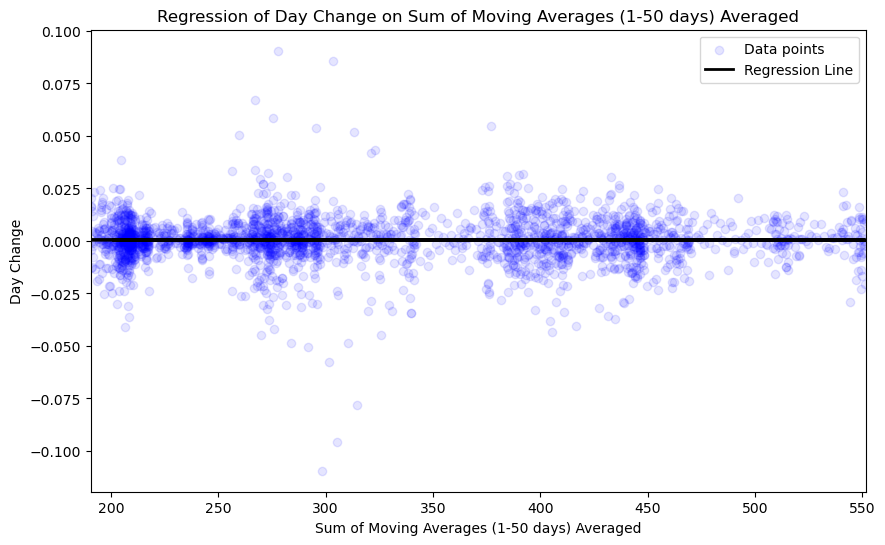



Exactly. The OLS results show that the average of the MAs isn't predictive for day-to-day price changes. The small coefficient, 
high p-value, and low R-squared all suggest the sum of moving averages isn't a useful predictor.

This finding aligns with your earlier insights about the lack of significance in individual moving averages. So, it seems like moving
averages, at least in these configurations, don't offer predictive power for daily changes.




In [13]:
# Initialize the column to store the sum of moving averages
data['Sum_MA_1_50'] = 0

# Calculate and sum the moving averages from 1 to 50 days
for i in range(1, 51):
    # Calculate the moving average for each window size 'i'
    ma = data['Close/Last'].rolling(window=i).mean()
    # Add the calculated moving average to 'Sum_MA_1_50'
    data['Sum_MA_1_50'] += ma

# Divide by 50 to get the average
data['Sum_MA_1_50_Avg'] = data['Sum_MA_1_50'] / 50

# Ensure 'day_change' is defined
data['day_change'] = (data['Close/Last'] - data['Close/Last'].shift(1)) / data['Close/Last'].shift(1)

# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['Sum_MA_1_50_Avg', 'day_change'])

# Independent variable and dependent variable
X = clean_data[['Sum_MA_1_50_Avg']]
y = clean_data['day_change']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(clean_data['Sum_MA_1_50_Avg'], clean_data['day_change'], color='blue', alpha=0.1, label='Data points')

# Plot the regression line
plt.plot(clean_data['Sum_MA_1_50_Avg'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Sum of Moving Averages (1-50 days) Averaged')
plt.ylabel('Day Change')
plt.title('Regression of Day Change on Sum of Moving Averages (1-50 days) Averaged')

# Set the x-axis limit to fit the range of 'Sum_MA_1_50_Avg'
plt.xlim(clean_data['Sum_MA_1_50_Avg'].min(), clean_data['Sum_MA_1_50_Avg'].max())

# Add legend
plt.legend()

# Show and save the plot
plt.show()

print('''

Exactly. The OLS results show that the average of the MAs isn't predictive for day-to-day price changes. The small coefficient, 
high p-value, and low R-squared all suggest the sum of moving averages isn't a useful predictor.

This finding aligns with your earlier insights about the lack of significance in individual moving averages. So, it seems like moving
averages, at least in these configurations, don't offer predictive power for daily changes.

''')
